In [1]:
import os
from alarms import *
print(pio.renderers)
# pio.renderers = "png"

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']



### Enter Input Variables to the script

In [2]:
input_fname = "formatted-pre-2-mayis2019.csv"
include_iops = True
num_top_sensors = 15 # include the sensors top x sensors which trigger most alarms
num_top_conditions = 10
chatter_filter = 100 # only consider those sources in which chattering happend more than these many times 

In [3]:
path = "./data/new/"
df_csv = pd.read_csv(path + input_fname,low_memory=False, parse_dates = ["StartTime", "EndTime"])
# print("Before:",df["SourceName"].unique())
maskSourceNames(df_csv)
# print("After:",df["SourceName"].unique())
# df["Time"] = df["Time"].apply(lambda d: datetime.strptime(d,"%H:%M").time())
df_csv["TimeDelta"] = df_csv["EndTime"] - df_csv["StartTime"]
df_csv["TimeDelta"] = df_csv["TimeDelta"].apply(lambda arg: timedelta.total_seconds(arg))
df_csv["Month"] = df_csv["StartTime"].apply(lambda arg: arg.month)
df_csv.head(2)

,MachineName,SourceName,Message,Quality,Condition,Mask,NewState,Status,MessageType,StartTime,EndTime,EndMessage,TimeDelta,Month
0,PHD47B,S1,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.8 C VEL+,192,VEL+,193,3,0,Activation,2019-05-01 00:00:02,2019-05-01 00:00:03,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.9 C VEL+...,1.0,5
1,PHD47B,S1,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.8 C VEL+,192,VEL+,193,3,0,Activation,2019-05-01 00:00:10,2019-05-01 00:00:12,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.3 C VEL+...,2.0,5


In [4]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868725 entries, 0 to 868724
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   MachineName  868725 non-null  object        
 1   SourceName   868725 non-null  object        
 2   Message      868725 non-null  object        
 3   Quality      868725 non-null  int64         
 4   Condition    868725 non-null  object        
 5   Mask         868725 non-null  int64         
 6   NewState     868725 non-null  int64         
 7   Status       868725 non-null  int64         
 8   MessageType  868725 non-null  object        
 9   StartTime    868725 non-null  datetime64[ns]
 10  EndTime      868725 non-null  datetime64[ns]
 11  EndMessage   868725 non-null  object        
 12  TimeDelta    868725 non-null  float64       
 13  Month        868725 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(6)
memory usage: 92.8+ MB


In [5]:
s = df_csv["TimeDelta"].describe()
print("TimeDelta Summary: min = {}, Q1 = {}, Q2 = {}, Q3= {}, max = {}, mean={}".format(s["min"], s["25%"],s["50%"], s["75%"], s["max"], s["mean"]))
np.quantile(df_csv["TimeDelta"], .55)

TimeDelta Summary: min = 1.0, Q1 = 1.0, Q2 = 2.0, Q3= 3.0, max = 2251718.0, mean=235.8776747532303


2.0

# Section 1: Generic Analyis of Per Month Data 
The following scatter graphs shows all the alarms triggered in each motnh. The x-axis represents the activation time of an alarm, and the y-axis shows the duration (i.e., TimeDelta= StartTime - EndTime) of the corresponding activation. 

The Box plot will help us to determine the threshold for TimeDelta. If the duration between activation and deactivation (i.e., TimeDelta = Deactivation - Activation) is less than the threshold then we will not transmit such alarm to the historian. 

Note: All the TimeDelta values are in seconds. In some cases, the box plot will not fit properly in the figure so I printed the values of Q1, Q2, Q3 etc.  

In [6]:
for month in sorted(df_csv["Month"].unique()):    
    print("================ Month :  {}==============".format(month))
    
    df_month = df_csv.loc[df_csv['Month'].isin([month])]
    _,total_alarms_in_all_chatters = getChatteringAlarmsFromDataFrame(df_month)

    
    fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5])
    x_axis = ["Normal Alarms", "Chattering Alarms"]
    y_axis = [df_month.shape[0]-total_alarms_in_all_chatters, total_alarms_in_all_chatters]

    print("Y-axis",y_axis)
    
    trace_bar = go.Bar(x=x_axis, y=y_axis, text=y_axis)
    trace_box = go.Box(y=df_month["TimeDelta"], text=df_month["TimeDelta"])
    s = df_month["TimeDelta"].describe()
    print("TimeDelta Summary: min = {}, Q1 = {}, Q2 = {}, Q3= {}, max = {}, mean={}".format(s["min"], s["25%"], s["50%"], s["75%"], s["max"], s["mean"]))
    # print(s)

    # Adding traces
#     fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace_bar, row=1, col =1)
    fig.add_trace(trace_box, row=1, col=2)
    
    # Updates
    fig.update_layout(height=600, width=1000)
    fig.update_layout(title_text="Month {}".format(month))
    
    # Updates y_axis
    fig.update_yaxes(row =1, col = 2, range = [0,1000])
    fig.show(renderer="png")
    
    df_month = df_csv.loc[df_csv['Month'].isin([month])]
    fig = px.scatter(x=df_month["StartTime"], y = df_month["TimeDelta"])
    # fig.update_xaxes("title")
    fig.show(renderer="png")

================ Month :  5==============


AssertionError: 

# Section 2: Analyis of Individual Source Name (Sensors)
From the histograms, we can see that some sensors triggered the most number of alarms. 

### Chattering
If an alarm from the same source is triggered 3 times or less then within a minute then such situations of chattering are considered as normal. However, from the following the histograms, we can see that thousands of alarms are triggered more than thrice in most of the sensors. 

Personal Note: Check the chattering graphs again... 

In [7]:
# # # All months data analysis of top sensors
# print("=========== All Months ====================")
# temp_s = df_csv['SourceName'].value_counts()
# df_of_top_x_sensors = df_csv.loc[df_csv['SourceName'].isin(temp_s.keys()[:num_top_sensors])]

# fig = px.histogram(df_of_top_x_sensors, x = "SourceName")
# fig.update_xaxes(title_text='Source Name')
# fig.update_yaxes(title_text='# of triggered alarms')
# fig.show(renderer="png")

# # fig = px.histogram(df, x = "SourceName", color="Condition",  barmode='group')
# # fig.update_layout(title="Number of times a condition occured for a SourceName.")
# # fig.show()

# fig = px.box(df_of_top_x_sensors, x= "SourceName", y="TimeDelta",notched=True)
# fig.update_yaxes(range=[0, 1000], title_text='Alarm activation duration (seconds)')
# fig.update_xaxes(title_text='Source Name')
# fig.show(renderer="png")

# Per Month data analysis of top alarms in each month
for month in sorted(df_csv["Month"].unique()):
    
    print("================ Month :  {}==============".format(month))
    df_month = df_csv.loc[df_csv['Month'].isin([month])] # Selecting month DF

    # Chattering
    chatters,total_alarms_in_all_chatters = getChatteringAlarmsFromDataFrame(df_month)
    chatters = list(filter(lambda arg: arg[1]>chatter_filter, chatters)) # alarms which chattered more than chatter_filter
    
    # Top Sensors in the month based on alarms
    temp_s = df_month['SourceName'].value_counts()   
    df_top = df_month.loc[df_month['SourceName'].isin(temp_s.keys()[:num_top_sensors])]
    
    
    # Graphs
    trace1 = go.Histogram(x=df_top["SourceName"])
    trace2 = go.Box(x=df_top["SourceName"], y=df_top["TimeDelta"])
    trace3 = go.Bar(x=["Normal Alarms", "Chattering Alarms"],y = [df_month.shape[0]-total_alarms_in_all_chatters ,total_alarms_in_all_chatters])
    trace4 = go.Bar(x=[t[0] for t in chatters], y=[t[2] for t in chatters])

    fig = make_subplots(rows=2, cols=2)
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=1, col =2)
    fig.add_trace(trace3, row=2, col =1)
    fig.add_trace(trace4, row=2, col =2)
    fig.update_yaxes(row =1, col = 2, range = [0,1000])
    # fig.update_layout(height=600, width=1000)
    fig.show(renderer="png")
    

================ Month :  5==============


AssertionError: 

# Section 3: Analysis of alarms based on "Conditions"

As we can see from the following graphs, some conditions are more prevalent as compared to others in alarms e.g., the most frequent alarms are related to communication problems. Additionally, from the box plot, we can see that that durations (i.e., Timedelta = deactivation time - activation time) of IOP alarms are shorter.


========= All Months ===========


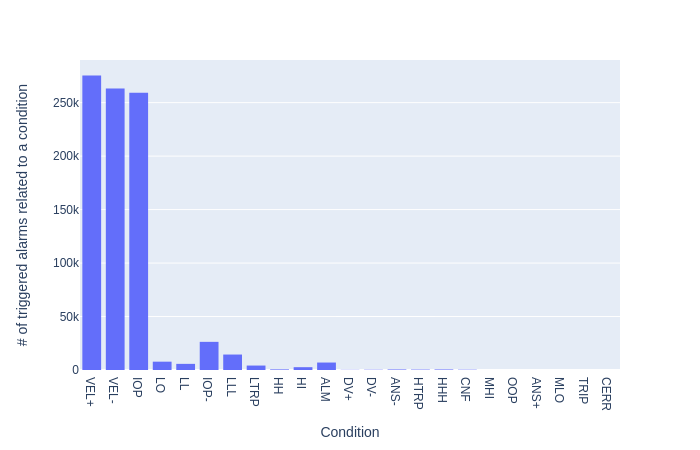

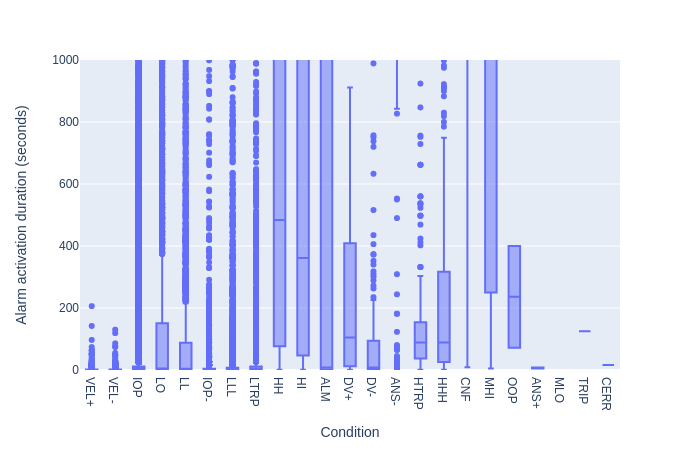

================ Month :  5==============


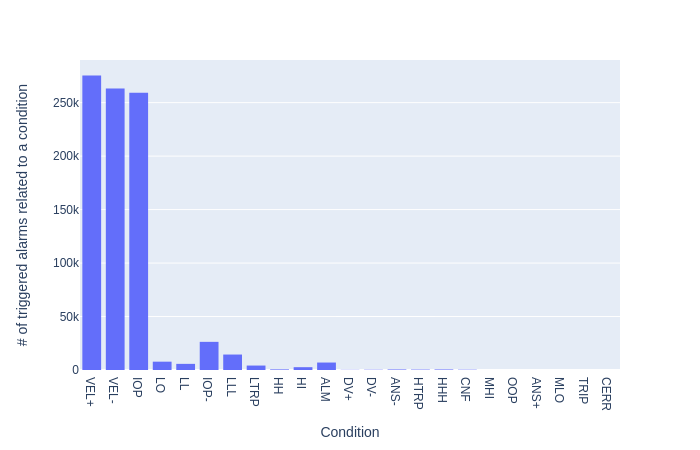

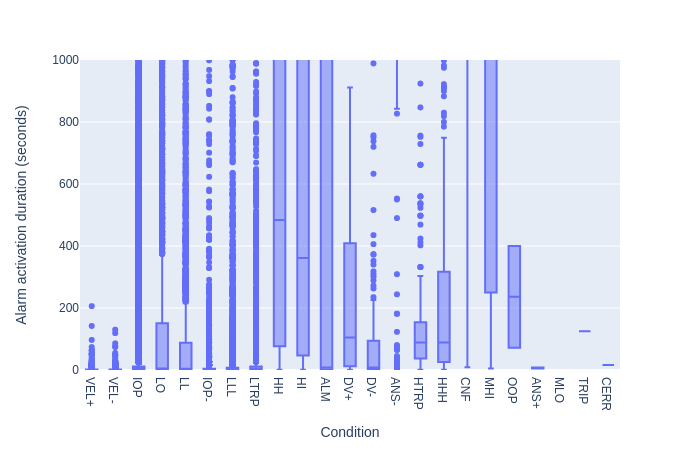

In [8]:
## Overall 

print("========= All Months ===========")

fig = px.histogram(df_csv, x = "Condition")
fig.update_xaxes(title_text='Condition')
fig.update_yaxes(title_text='# of triggered alarms related to a condition')
fig.show(renderer="png")

fig = px.box(df_csv, x= "Condition", y="TimeDelta")
fig.update_yaxes(range=[0, 1000], title_text='Alarm activation duration (seconds)')
fig.show(renderer="png")

# Per Month
for month in sorted(df_csv["Month"].unique()):
    print("================ Month :  {}==============".format(month))
    df_month = df_csv.loc[df_csv['Month'].isin([month])]

    fig = px.histogram(df_month, x = "Condition")
    fig.update_xaxes(title_text='Condition')
    fig.update_yaxes(title_text='# of triggered alarms related to a condition')
    fig.show(renderer="png")

    fig = px.box(df_month, x= "Condition", y="TimeDelta")
    fig.update_yaxes(range=[0, 1000], title_text='Alarm activation duration (seconds)')
    fig.show(renderer="png")
    

# Section 4:  Time Between form one Deactivation to Next Activation for whole Data

In ideal scenario, there should be 1 alarm per minute. However, when we we can see from the following output that the time difference between 1 deactivation to the next activation of any alarm the difference (delta) was mostly under 10 seconds which means that a huge number alarms are generated in 1 minute.

**Note: The first value in the tuple represents the time delta (i.e., the time difference between deactivation and activation of an alarm), while the second value represents the frequency (count) of corresponding deltas.**



In [9]:
for month in sorted(df_csv["Month"].unique()):
    print("================ Month :  {}==============".format(month))
    # if month == 5:
    #     continue
    df_month = df_csv.loc[df_csv['Month'].isin([month])]
    alarms = df_month.to_dict(orient="records")
    durations = frequencyOfAlarmsActivated(alarms)
    d = {}
    for v in durations:
        d[v] = 0

    for v in durations:
        d[v] +=1

    counts = [v for v in d.values()]
    deltas = [k for k in d.keys()]

    for delta in sorted(d.keys()):
        print(("{:.2f}".format(delta/60), d[delta]), end="")
    print("\n")
# (0.0, 404001) (1.0, 142133) (2.0, 171784) (3.0, 58800) (4.0, 52553) (5.0, 31374) (6.0, 21085) (7.0, 12020) (8.0, 7067) (9.0, 6146) (10.0, 3887) (11.0, 3134) (12.0, 2634) (13.0, 1276) (14.0, 962) (15.0, 188) (16.0, 236) (17.0, 75) (18.0, 30) (19.0, 14) (20.0, 11) (21.0, 13) (22.0, 9) (23.0, 4) (24.0, 2) (25.0, 4) (26.0, 1) (28.0, 1) (174.0, 1) (330.0, 1) (90403.0, 1) (90404.0, 1)


================ Month :  5==============
('0.00', 376753)('0.02', 142954)('0.03', 168634)('0.05', 59742)('0.07', 50646)('0.08', 26895)('0.10', 18014)('0.12', 8652)('0.13', 4964)('0.15', 4360)('0.17', 2427)('0.18', 1983)('0.20', 1335)('0.22', 602)('0.23', 455)('0.25', 94)('0.27', 110)('0.28', 39)('0.30', 19)('0.32', 13)('0.33', 7)('0.35', 8)('0.37', 2)('0.38', 1)('0.40', 1)('0.42', 1)('0.43', 1)('0.48', 1)('0.93', 1)('1.20', 1)('1.83', 1)('6.45', 1)('6.52', 1)('12.20', 1)('18.05', 1)('32.62', 1)('32.88', 1)('112.92', 1)('1440.05', 1)



# End